<a href="https://www.kaggle.com/code/arnaud58/variational-autoencoders-on-the-witness?scriptVersionId=99761834" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Variational Auto-encoders for anime faces
This notebook is referred from the below article which was really useful
Reference: https://learnopencv.com/variational-autoencoder-in-tensorflow/#network-fmnist

In [1]:
import os
import sys
import time
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from keras.models import load_model
from keras.models import Model
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
print("Python version :", sys.version, "\nTF version     :", tf.version.VERSION, "\nNumpy version  :", np.version.version, "\n")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU') 

Python version : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0] 
TF version     : 2.6.4 
Numpy version  : 1.21.6 

Num GPUs Available:  1


2022-07-01 08:39:17.672537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 08:39:17.825761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 08:39:17.826680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def freeze_layers(model):
    for i in model.layers:
        i.trainable = False
        if isinstance(i, Model):
            freeze_layers(i)
    return model

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
img_height, img_width = 256, 256
batch_size = 128

In [6]:
!mkdir /kaggle/the-witness

In [7]:
%%time
path_source = "/kaggle/input/the-witness"
path_dest_train   = "/kaggle/the-witness"
limit=5000 
exclude=[]
begin_file=0
size = (img_height, img_width)

path_source_list = os.listdir(path_source)

start = time.time()
cpt = 0
for image_path in path_source_list :
    if image_path not in exclude and cpt >= begin_file :
        img = Image.open(path_source+"/"+image_path)
        width, height = img.size
        if cpt == begin_file+limit :
            break

        if width > height :
            dp = width-height
            img = img.crop((0+(dp/2), 0, width-(dp/2), height))
        elif height > width :
            dp = height-width
            img = img.crop((0, 0+(dp/2), width, height-(dp/2)))

        try:
            img = img.resize(size, Image.ANTIALIAS)
        except AttributeError as e:
            print('got error, but skip and do it again.')
            img = img.resize(size, Image.ANTIALIAS)
        
        img = img.convert('RGB')
        img.save(path_dest_train+"/"+image_path[:-4]+".jpg")
            
    cpt += 1

end = time.time()
print("Resize : ",cpt-begin_file, " elements in ",end - start," secondes")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


Resize :  714  elements in  47.610597133636475  secondes
CPU times: user 37.6 s, sys: 1.18 s, total: 38.8 s
Wall time: 47.8 s


In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_dest_train,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=None)

Found 709 files belonging to 1 classes.


2022-07-01 08:40:06.822386: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-01 08:40:06.822885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 08:40:06.823722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 08:40:06.824379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

2022-07-01 08:40:09.448797: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


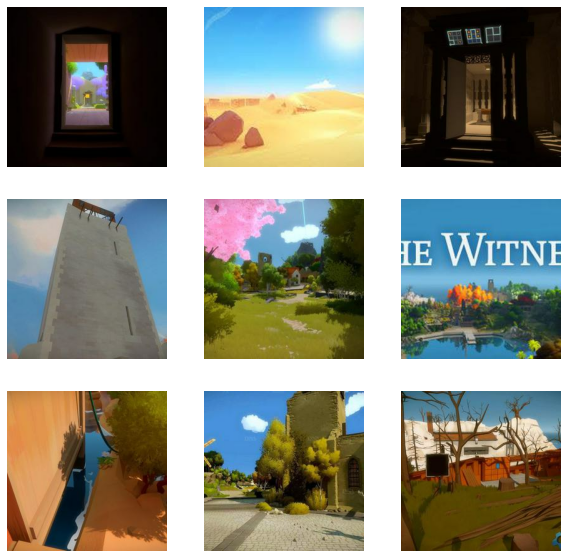

In [9]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)

In [11]:
normalized_ds = train_ds.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [12]:
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [13]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    return mean + K.exp(log_var / 2) * epsilon

In [14]:
input_encoder = tuple(first_image.shape)
input_decoder = (200,)

In [15]:
def encoder(input_encoder):
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    
    # Block-1
    x = layers.Conv2D(128, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
  
    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    x = layers.Dropout(0.2)(x)
   
    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
  
    # Block-4
    x = layers.Conv2D(32, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
 

    # Final Block
    flatten = layers.Flatten()(x)
    mean = layers.Dense(200, name='mean')(flatten)
    log_var = layers.Dense(200, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

In [16]:
enc = encoder(input_encoder)

In [17]:
enc.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 128, 128 3584        input_layer[0][0]                
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 128, 128, 128 512         conv_1[0][0]                     
__________________________________________________________________________________________________
lrelu_1 (LeakyReLU)             (None, 128, 128, 128 0           bn_1[0][0]                       
____________________________________________________________________________________________

In [18]:
input_1 = (200,)
input_2 = (200,)

In [19]:
def sampling(input_1,input_2):
    #input1 = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    out = layers.Lambda(sampling_model, name='encoder_output')([mean, log_var])
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    return enc_2

In [20]:
final = sampling(input_1,input_2)

In [21]:
final = load_model("/kaggle/input/variational-autoencoders-on-the-witness/sampling-anime.h5")
final.save('sampling-anime.h5')

In [22]:
def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    x = layers.Reshape((8,8,64), name='Reshape')(x)
    
    # Block-1
    x = layers.Conv2DTranspose(32, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
   
    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
 
    # Block-3
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
   
    # Block-4
    x = layers.Conv2DTranspose(128, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)

  
    # Block-5
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [23]:
dec = decoder(input_decoder)

In [24]:
dec.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 200)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              823296    
_________________________________________________________________
Reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
conv_transpose_1 (Conv2DTran (None, 16, 16, 32)        18464     
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 16, 16, 32)        128       
_________________________________________________________________
lrelu_1 (LeakyReLU)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv_transpose_2 (Conv2DTran (None, 32, 32, 64)        1849

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)

In [26]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss

def kl_loss(mean, log_var):
    kl_loss_ =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss_

def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss_ = kl_loss(mean, log_var)
    return  r_loss + kl_loss_

In [27]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        mean, log_var = enc(images, training=True)
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)

        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [28]:
os.makedirs('./tf_vae/anime/training_weights', exist_ok=True)
os.makedirs('./tf_vae/anime/images', exist_ok=True)

In [29]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            loss_.append(loss)

        #print("Loss",np.mean(loss_))    
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([enc,final,dec],
                                  epoch + 1,
                                  seed)
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        # enc.save_weights('tf_vae/anime/training_weights/enc_'+ str(epoch)+'.h5')
        # dec.save_weights('tf_vae/anime/training_weights/dec_'+ str(epoch)+'.h5')
        
        enc.save('tf_vae/anime/training_weights/enc_'+ str(epoch)+'.h5')
        dec.save('tf_vae/anime/training_weights/dec_'+ str(epoch)+'.h5')
        
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([enc,final,dec],
                            epochs,
                            seed)

In [30]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    mean, var = enc(test_input, training=False)
    latent = final([mean, var])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = predictions[i, :, :, :] * 255
        pred = np.array(pred)  
        pred = pred.astype(np.uint8)
        #cv2.imwrite('tf_ae/images/image'+ str(i)+'.png',pred)
        
        plt.imshow(pred)
        plt.axis('off')

    plt.savefig('./tf_vae/anime/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

In [31]:
enc = load_model("/kaggle/input/variational-autoencoders-on-the-witness/tf_vae/anime/training_weights/enc_999.h5")
dec = load_model("/kaggle/input/variational-autoencoders-on-the-witness/tf_vae/anime/training_weights/dec_999.h5")

(25, 256, 256, 3)


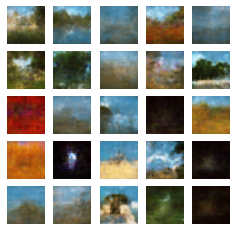

In [32]:
n_epoches = 1000
is_train=True
if is_train==True:
    train(normalized_ds, n_epoches)

In [33]:
reconstruction_shape = 1000

In [34]:
embeddings = None
mean = None
var = None
for i in normalized_ds:
    m,v = enc.predict(i)
    embed = final.predict([m,v])
    #embed = dec.predict(latent)
    if embeddings is None:
        embeddings = embed
        mean = m
        var = v
    else:
        embeddings = np.concatenate((embeddings, embed))
        mean = np.concatenate((mean, m))
        var = np.concatenate((var, v))
    if embeddings.shape[0] > reconstruction_shape:
        break

In [35]:
embeddings.shape

(709, 200)

## Latent Space Projection with t-SNE of VAE Trained on Cartoon Set

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


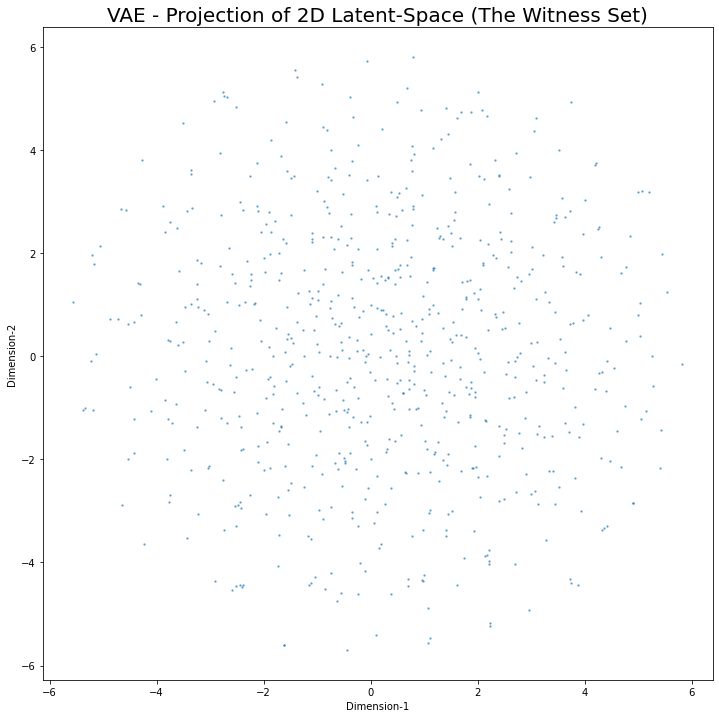

In [36]:
n_to_show = 5000
grid_size = 15
figsize = 12

tsne = TSNE(n_components=2, init='pca', random_state=0, learning_rate=100)
X_tsne = tsne.fit_transform(embeddings)
min_x = min(X_tsne[:, 0])
max_x = max(X_tsne[:, 0])
min_y = min(X_tsne[:, 1])
max_y = max(X_tsne[:, 1])


plt.figure(figsize=(figsize, figsize))
plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=10)
plt.ylabel("Dimension-2", size=10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.title("VAE - Projection of 2D Latent-Space (The Witness Set)", size=20)
plt.show()

In [37]:
reconstruction = None
lat_space = None
for i in normalized_ds:
    m,v = enc.predict(i)
    latent = final([m,v])
    out = dec.predict(latent)
    if reconstruction is None:
        reconstruction = out
        lat_space = latent
    else:
        reconstruction = np.concatenate((reconstruction, out))
        lat_space = np.concatenate((lat_space, latent))
    if reconstruction.shape[0] > reconstruction_shape:
        break

In [38]:
reconstruction.shape

(709, 256, 256, 3)

## Reconstructing Test Images

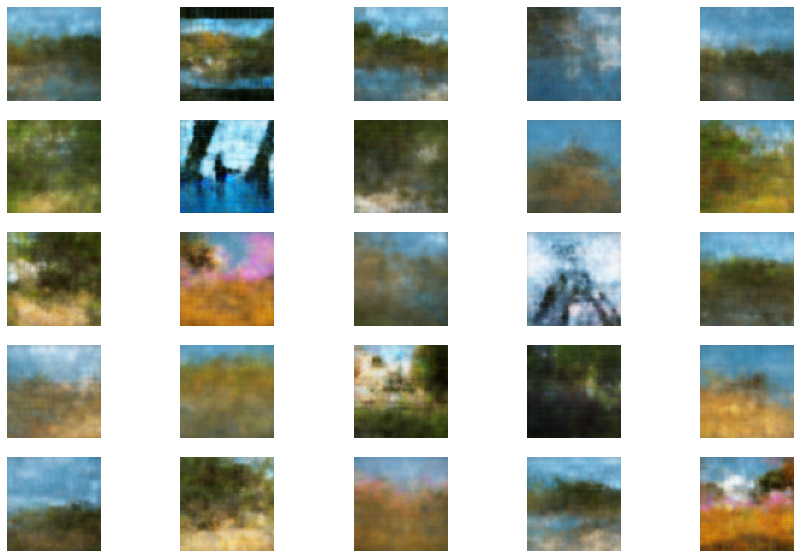

In [39]:
figsize = 15


fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruction[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    
    ax.imshow(pred)

## Reconstructing Anime Images from a Latent-Vector Sampled with Normal Distribution

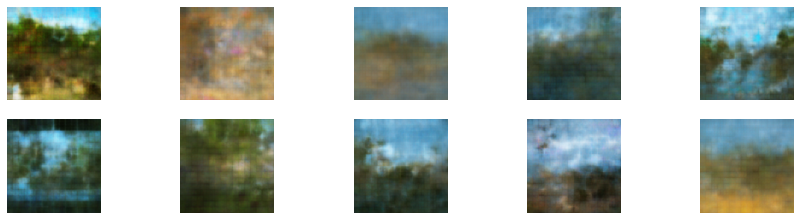

In [40]:
figsize = 15


x = np.random.normal(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

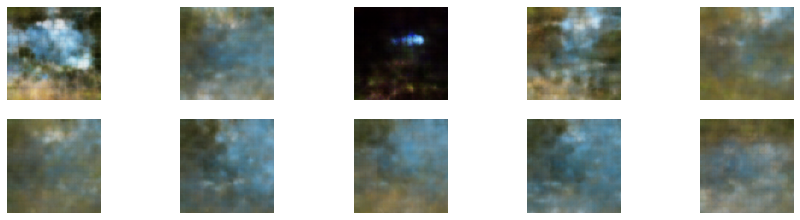

In [41]:
figsize = 15
x = np.random.exponential(scale=0.7, size = (50,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

## Reconstructing Cartoon Images with Latent-Vector Samples from different ranges

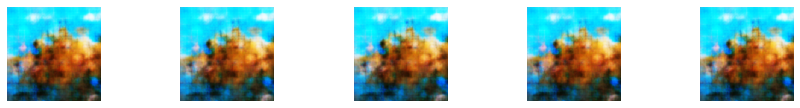

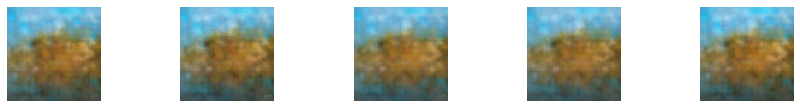

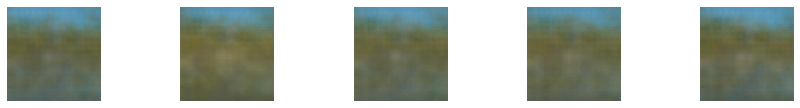

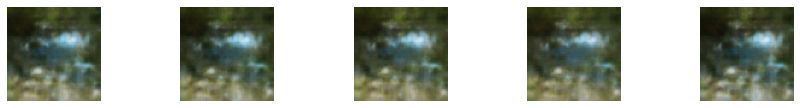

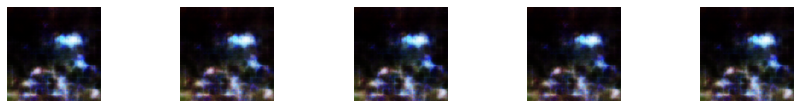

In [42]:
figsize = 15

for var_factor in range(-2, 3, 1):
    min_x = lat_space.min(axis=0)
    max_x = lat_space.max(axis=0)
    x = np.random.uniform(size = (10,200))
    x = x * (max_x - (np.abs(min_x))) + var_factor
    #print("value "+str(var_factor))
    reconstruct = dec.predict(x)


    fig = plt.figure(figsize=(figsize, 10))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    fig.set_label("value "+str(var_factor))

    for i in range(5):
        ax = fig.add_subplot(5, 5, i+1)
        ax.axis('off')
        pred = reconstruct[i, :, :, :] * 255
        pred = np.array(pred)  
        pred = pred.astype(np.uint8)
        ax.imshow(pred)